In [619]:
%matplotlib widget

In [620]:
import sympy as sp
import sympy.physics.mechanics as me
import sympy.plotting as splt
from typing import List
from sympy import sin, cos, pi, sqrt, acos, simplify, atan
import math
me.init_vprinting()


def homogeneous(rotation: sp.Matrix = sp.eye(3), translation: sp.Matrix = sp.zeros(3, 1)) -> sp.Matrix:
    return rotation.row_join(translation).col_join(sp.Matrix([[0, 0, 0, 1]]))

def dh(rotation, twist, displacement, offset):
    rotation_mat = sp.Matrix([
        [cos(rotation), -sin(rotation)*cos(twist),  sin(rotation)*sin(twist)],
        [sin(rotation), cos(rotation)*cos(twist),   -cos(rotation)*sin(twist)],
        [0,             sin(twist),                 cos(twist)],
    ])
    translation = sp.Matrix([
        [offset*cos(rotation)],
        [offset*sin(rotation)],
        [displacement],
    ])
    return rotation_mat, translation

def rotation(homogeneous: sp.Matrix):
    return homogeneous[:3, :3]

def translation(homogeneous: sp.Matrix):
    return homogeneous[:3, 3:]

def jacobian(transforms: List[sp.Matrix], joint_types: List[sp.Matrix], base_z: sp.Matrix = sp.Matrix([0, 0, 1])):
    transforms_chained = [homogeneous()]
    z_unit_vecs = []
    # chain the transforms
    for i, transform in enumerate(transforms):
        transforms_chained.append(transforms_chained[-1] * transform)
    # apply rotation of chained transforms to base z
    for chained_transform in transforms_chained:
        z_unit_vecs.append(rotation(chained_transform) * base_z)
    
    assert len(transforms_chained) == len(z_unit_vecs)

    jacobian = sp.zeros(6, len(transforms))
    for i, (transform, joint_type) in enumerate(zip(transforms, joint_types)):
        if joint_type == 'revolute':
            jacobian[:3, i] = z_unit_vecs[i].cross(translation(transforms_chained[-1]) - translation(transforms_chained[i]))
            jacobian[3:, i] = z_unit_vecs[i]
        elif joint_type == 'prismatic':
            jacobian[:3, i] = z_unit_vecs[i]
            jacobian[3:, i] = sp.Matrix([[0], [0], [0]])

        # angular velocity

    return jacobian

def skew(v: sp.Matrix):
    return sp.Matrix([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0],
    ])

In [621]:
"""
Design the robot
"""
t = sp.symbols('t')

# Design Parameters
l_arm = sp.symbols('l_{arm}')

# Joint Variables
# turret_theta, elev_dist, shoulder_theta, wrist_theta = me.dynamicsymbols('theta_1 d_01 theta_2 theta_3')
turret_theta, elev_dist, shoulder_theta, wrist_theta = sp.symbols('theta_1 d_01 theta_2 theta_3')
turret_theta_dot, elev_dist_dot, shoulder_theta_dot, wrist_theta_dot =  sp.symbols('theta_1_dot d_01_dot theta_2_dot theta_3_dot')

q = sp.Matrix([turret_theta, elev_dist, shoulder_theta, wrist_theta])
q_dot = sp.Matrix([turret_theta_dot, elev_dist_dot, shoulder_theta_dot, wrist_theta_dot])

# Joint Transforms
turret = homogeneous(*dh(turret_theta, 0, 0, 0))
elevator = homogeneous(*dh(0, pi/2, elev_dist, 0))
shoulder = homogeneous(*dh(shoulder_theta, 0, 0, l_arm))
wrist = homogeneous(*dh(wrist_theta, 0, 0, 0))


display(turret)
display(elevator)
display(shoulder)
display(turret * elevator * shoulder * wrist)

⎡cos(θ₁)  -sin(θ₁)  0  0⎤
⎢                       ⎥
⎢sin(θ₁)  cos(θ₁)   0  0⎥
⎢                       ⎥
⎢   0        0      1  0⎥
⎢                       ⎥
⎣   0        0      0  1⎦

⎡1  0  0    0 ⎤
⎢             ⎥
⎢0  0  -1   0 ⎥
⎢             ⎥
⎢0  1  0   d₀₁⎥
⎢             ⎥
⎣0  0  0    1 ⎦

⎡cos(θ₂)  -sin(θ₂)  0  l_{arm}⋅cos(θ₂)⎤
⎢                                     ⎥
⎢sin(θ₂)  cos(θ₂)   0  l_{arm}⋅sin(θ₂)⎥
⎢                                     ⎥
⎢   0        0      1         0       ⎥
⎢                                     ⎥
⎣   0        0      0         1       ⎦

⎡-sin(θ₂)⋅sin(θ₃)⋅cos(θ₁) + cos(θ₁)⋅cos(θ₂)⋅cos(θ₃)  -sin(θ₂)⋅cos(θ₁)⋅cos(θ₃) 
⎢                                                                             
⎢-sin(θ₁)⋅sin(θ₂)⋅sin(θ₃) + sin(θ₁)⋅cos(θ₂)⋅cos(θ₃)  -sin(θ₁)⋅sin(θ₂)⋅cos(θ₃) 
⎢                                                                             
⎢        sin(θ₂)⋅cos(θ₃) + sin(θ₃)⋅cos(θ₂)                   -sin(θ₂)⋅sin(θ₃) 
⎢                                                                             
⎣                        0                                                   0

- sin(θ₃)⋅cos(θ₁)⋅cos(θ₂)  sin(θ₁)   l_{arm}⋅cos(θ₁)⋅cos(θ₂)⎤
                                                            ⎥
- sin(θ₁)⋅sin(θ₃)⋅cos(θ₂)  -cos(θ₁)  l_{arm}⋅sin(θ₁)⋅cos(θ₂)⎥
                                                            ⎥
+ cos(θ₂)⋅cos(θ₃)             0       d₀₁ + l_{arm}⋅sin(θ₂) ⎥
                                                            ⎥
                              0                 1           ⎦

In [622]:
"""
Find the Jacobian
"""

# Compute the Jacobian matrix
J = jacobian([turret, elevator, shoulder, wrist], ['revolute', 'prismatic', 'revolute', 'revolute'])

# Sanity check the Jacobian for elevator
pos = {
    # Design Parameters
    l_arm: 0.5,
    # Joint Variables
    turret_theta: 0,
    shoulder_theta: 0,
    wrist_theta: 0,
}
vel = {
    turret_theta_dot: 0,
    shoulder_theta_dot: 0,
    wrist_theta_dot: 0,
}

# In this case joint_state represents joint velocities
display(J.subs(pos) * q_dot.subs(vel))
display(J)

⎡   0    ⎤
⎢        ⎥
⎢   0    ⎥
⎢        ⎥
⎢d_01_dot⎥
⎢        ⎥
⎢   0    ⎥
⎢        ⎥
⎢   0    ⎥
⎢        ⎥
⎣   0    ⎦

⎡-l_{arm}⋅sin(θ₁)⋅cos(θ₂)  0               -l_{arm}⋅sin(θ₂)⋅cos(θ₁)           
⎢                                                                             
⎢l_{arm}⋅cos(θ₁)⋅cos(θ₂)   0               -l_{arm}⋅sin(θ₁)⋅sin(θ₂)           
⎢                                                                             
⎢                                        2                          2         
⎢           0              1  l_{arm}⋅sin (θ₁)⋅cos(θ₂) + l_{arm}⋅cos (θ₁)⋅cos(
⎢                                                                             
⎢           0              0                        sin(θ₁)                   
⎢                                                                             
⎢           0              0                       -cos(θ₁)                   
⎢                                                                             
⎣           1              0                           0                      

        0    ⎤
             ⎥
        0    ⎥
      

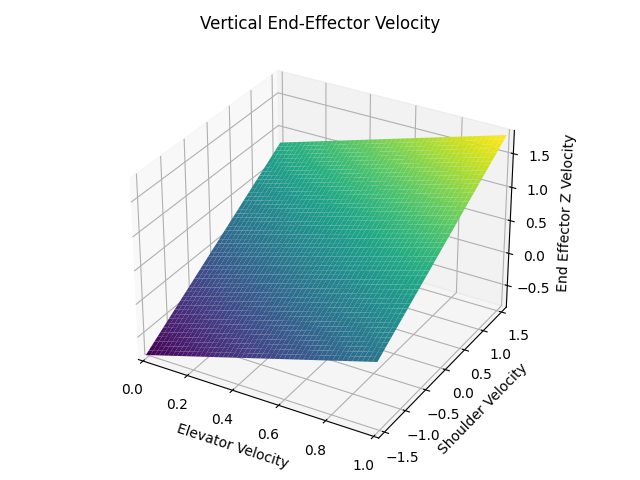

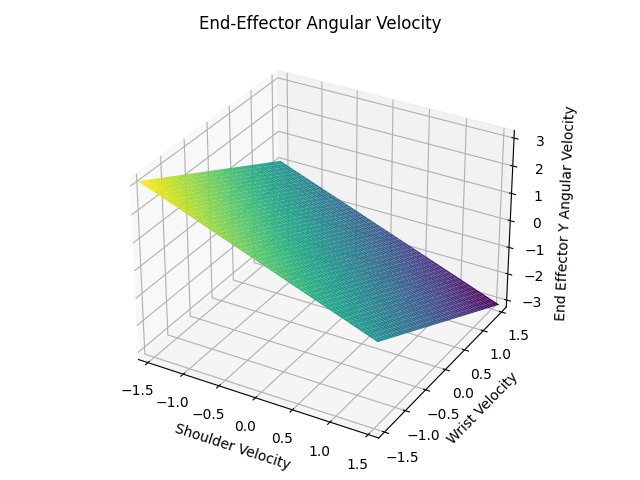

In [623]:
"""
Differential Kinematics Plots
"""

# Show that end-effector z velocity is dependent on elevator and shoulder
pos = {
    # Design Parameters
    l_arm: 0.5,
    # Joint Variables
    turret_theta: 0,
    elev_dist: 0,
    shoulder_theta: 0,
    wrist_theta: 0,
}
vel = {
    turret_theta_dot: 0,
    wrist_theta_dot: 0,
}

# In this case joint_state represents joint velocities
z_vel = J.subs(pos) * q_dot.subs(vel)
splt.plot3d(z_vel[2], (elev_dist_dot, 0, 1), (shoulder_theta_dot, -pi/2, pi/2), xlabel='Elevator Velocity', ylabel='Shoulder Velocity', zlabel='End Effector Z Velocity', title='Vertical End-Effector Velocity')

pos = {
    # Design Parameters
    l_arm: 0.5,
    # Joint Variables
    turret_theta: 0,
    elev_dist: 0,
    shoulder_theta: 0,
    wrist_theta: 0,
}
vel = {
    turret_theta_dot: 0,
    elev_dist_dot: 0,
    # shoulder_theta_dot: 0,
    # wrist_theta_dot: 0,
}

# In this case joint_state represents joint velocities
z_angular_vel = J.subs(pos) * q_dot.subs(vel)
splt.plot3d(z_angular_vel[4], (shoulder_theta_dot, -pi/2, pi/2), (wrist_theta_dot, -pi/2, pi/2), xlabel='Shoulder Velocity', ylabel='Wrist Velocity', zlabel='End Effector Y Angular Velocity', title='End-Effector Angular Velocity')

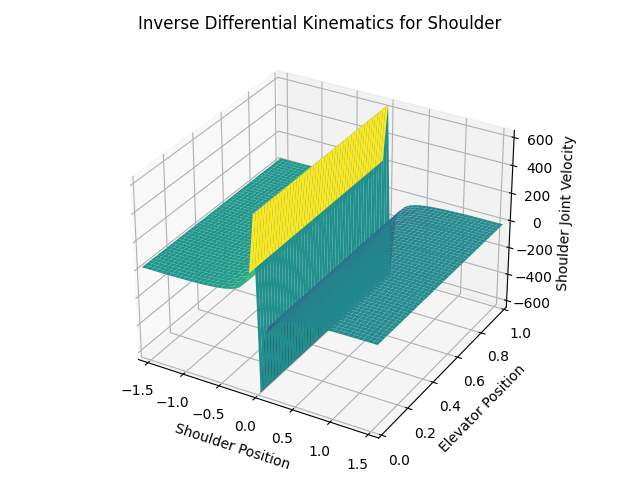

In [624]:
"""
Inverse Differential Kinematics Plots
"""

pos = {
    # Design Parameters
    l_arm: 0.5,
    # Joint Variables
    turret_theta: 0,
    # elev_dist: 0,
    # shoulder_theta: math.radians(-45),
    wrist_theta: 0,
}

p_dot = sp.Matrix([10, 0, 0, 0])

# Take determinant, remove uncontrolled end effector DoFs
J.row_del(3) # Angular velocity about x
J.row_del(4) # Angular velocity about y
J_inv = J.inv()
# In this case joint_state represents joint velocities
turret_angular_vel = (J_inv.subs(pos) * p_dot)[2]
display(turret_angular_vel)
splt.plot3d(turret_angular_vel, (shoulder_theta, -pi/2, pi/2), (elev_dist, 0, 1), xlabel='Shoulder Position', ylabel='Elevator Position', zlabel='Shoulder Joint Velocity', title='Inverse Differential Kinematics for Shoulder')

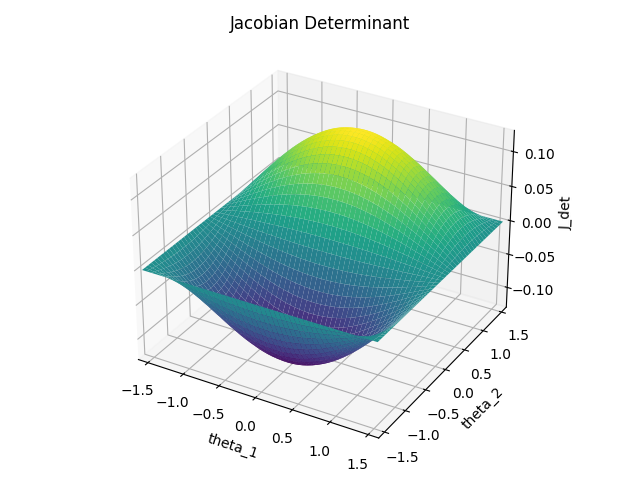

⎡-l_{arm}⋅sin(θ₁)⋅cos(θ₂)  0               -l_{arm}⋅sin(θ₂)⋅cos(θ₁)           
⎢                                                                             
⎢l_{arm}⋅cos(θ₁)⋅cos(θ₂)   0               -l_{arm}⋅sin(θ₁)⋅sin(θ₂)           
⎢                                                                             
⎢                                        2                          2         
⎢           0              1  l_{arm}⋅sin (θ₁)⋅cos(θ₂) + l_{arm}⋅cos (θ₁)⋅cos(
⎢                                                                             
⎣           0              0                       -cos(θ₁)                   

        0    ⎤
             ⎥
        0    ⎥
             ⎥
             ⎥
θ₂)     0    ⎥
             ⎥
     -cos(θ₁)⎦

In [625]:
"""
Find matrix singularities
"""


J_det = J.det()
splt.plot3d(J_det.evalf(subs={l_arm: 0.5}), (turret_theta, -pi/2, pi/2), (shoulder_theta, -pi/2, pi/2), xlabel='theta_1', ylabel='theta_2', zlabel='J_det', title='Jacobian Determinant')
display(J)
display(J_det)

In [626]:
"""
Force/Moment transformation
"""
base_to_end = turret*elevator*shoulder*wrist
# Find the transformation between frame 4 and 2
S = sp.zeros(6, 6)
R = rotation(base_to_end)
# Rotation from 4 to 2
S[0:3, 0:3] = R
S[3:6, 3:6] = R
# Displacement from 4 to 2
p = -translation(base_to_end)
S[0:3, 3:6] = skew(p) * R

display(simplify(R))
display(p)
display(simplify(S))
# Sanity check
# display(S.T*sp.Matrix([0, 0, 1, 0, 0, 0]))
display(simplify(S.evalf(subs={shoulder_theta: 0, wrist_theta: 0}).T*sp.Matrix([0, 0, 1, 0, 0, 0])))

⎡cos(θ₁)⋅cos(θ₂ + θ₃)  -sin(θ₂ + θ₃)⋅cos(θ₁)  sin(θ₁) ⎤
⎢                                                     ⎥
⎢sin(θ₁)⋅cos(θ₂ + θ₃)  -sin(θ₁)⋅sin(θ₂ + θ₃)  -cos(θ₁)⎥
⎢                                                     ⎥
⎣    sin(θ₂ + θ₃)          cos(θ₂ + θ₃)          0    ⎦

⎡-l_{arm}⋅cos(θ₁)⋅cos(θ₂)⎤
⎢                        ⎥
⎢-l_{arm}⋅sin(θ₁)⋅cos(θ₂)⎥
⎢                        ⎥
⎣ -d₀₁ - l_{arm}⋅sin(θ₂) ⎦

⎡cos(θ₁)⋅cos(θ₂ + θ₃)  -sin(θ₂ + θ₃)⋅cos(θ₁)  sin(θ₁)   (d₀₁⋅cos(θ₂ + θ₃) - l_
⎢                                                                             
⎢sin(θ₁)⋅cos(θ₂ + θ₃)  -sin(θ₁)⋅sin(θ₂ + θ₃)  -cos(θ₁)  (-d₀₁⋅cos(θ₂ + θ₃) + l
⎢                                                                             
⎢    sin(θ₂ + θ₃)          cos(θ₂ + θ₃)          0                            
⎢                                                                             
⎢         0                      0               0                  cos(θ₁)⋅co
⎢                                                                             
⎢         0                      0               0                  sin(θ₁)⋅co
⎢                                                                             
⎣         0                      0               0                      sin(θ₂

{arm}⋅sin(θ₃))⋅sin(θ₁)   -(d₀₁⋅sin(θ₂ + θ₃) + l_{arm}⋅cos(θ₃))⋅sin(θ₁)  -(d₀₁ 
                                                   

⎡   0   ⎤
⎢       ⎥
⎢  1.0  ⎥
⎢       ⎥
⎢   0   ⎥
⎢       ⎥
⎢   0   ⎥
⎢       ⎥
⎢   0   ⎥
⎢       ⎥
⎣l_{arm}⎦

In [627]:
J = jacobian([turret, elevator, shoulder, wrist], ['revolute', 'prismatic', 'revolute', 'revolute'])
f_x, f_y, f_z, m_x, m_y, m_z = sp.symbols('f_x f_y f_z m_x m_y m_z')
F = sp.Matrix([f_x, f_y, f_z, m_x, m_y, m_z])
t = simplify(-J.T*S.T*F)
# simplify(t)

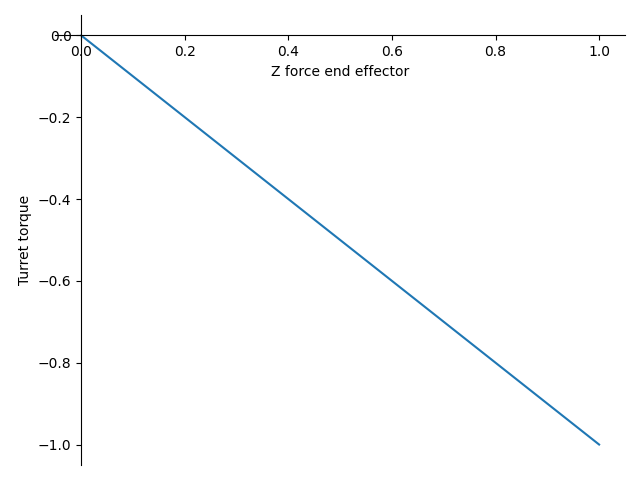

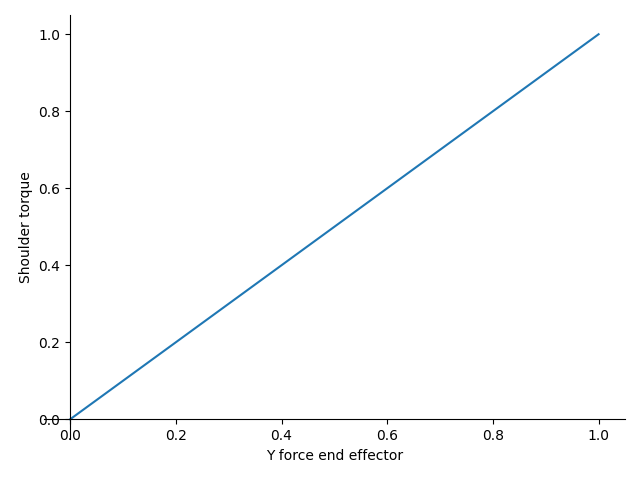

In [630]:
# display(simplify(t))
fs = {
    f_x: 0,
    f_y: 0,
    # f_z: 1,
    m_x: 0,
    m_y: 0,
    m_z: 0,
    turret_theta: 0,
    elev_dist: 0,
    shoulder_theta: 0,
    wrist_theta: 0,
    l_arm: 0.5,
}
result = t.evalf(subs=fs)[0]
display(result)
splt.plot(result, (f_z, 0, 1), xlabel='Z force end effector', ylabel='Turret torque',)
fs = {
    f_x: 0,
    # f_y: 0,
    f_z: 0,
    m_x: 0,
    m_y: 0,
    m_z: 0,
    turret_theta: 0,
    elev_dist: 0,
    shoulder_theta: 0,
    wrist_theta: 0,
    l_arm: 0.5,
}
result = t.evalf(subs=fs)[2]
splt.plot(result, (f_y, 0, 1), xlabel='Y force end effector', ylabel='Shoulder torque', title='')